In [1]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *
import timm

In [7]:
!nvidia-smi

Wed Mar  3 11:58:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 27%   35C    P8    23W / 250W |     10MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 27%   36C    P8    14W / 250W |     10MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [8]:
import torch
torch.cuda.set_device(1)

In [9]:
path = Path('datasetPrueba/')
trainPath = path/'train'
testPath = path/'test'

In [10]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = [Resize(presize)],
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=180,pad_mode=PadMode.Zeros), Normalize.from_stats(*imagenet_stats)])

In [11]:
db512 = getDataBlock(512,256)
dls512 = db512.dataloaders(trainPath,bs=64)

In [12]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='hrnet'),
    MixUp(),
]

In [13]:
learn = Learner(dls512, timm.models.hrnet.hrnet_w32(num_classes=2),cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy()).to_fp16()

In [14]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.567560,0.478183,0.806276,0.809111,0.837262,01:25


Better model found at epoch 0 with valid_loss value: 0.4781825542449951.


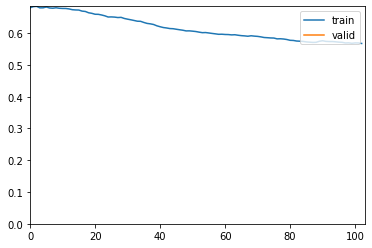

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.510030,0.452158,0.817139,0.916431,0.726150,01:24
1,0.502709,0.436693,0.823174,0.906250,0.748597,01:25
2,0.496210,0.424152,0.837055,0.880982,0.805836,01:25
3,0.492379,0.424713,0.831020,0.880448,0.793490,01:25
4,0.480244,0.433716,0.838262,0.905072,0.781145,01:25
5,0.478964,0.422766,0.847314,0.884337,0.823793,01:25
6,0.482890,0.422043,0.843693,0.901015,0.796857,01:25
7,0.475795,0.408136,0.853953,0.888623,0.832772,01:25
8,0.475368,0.414118,0.853953,0.886770,0.835017,01:25
9,0.473613,0.436757,0.830416,0.915531,0.754209,01:25


Better model found at epoch 0 with valid_loss value: 0.45215752720832825.


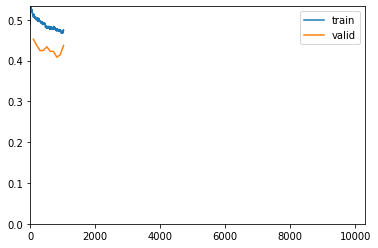

Better model found at epoch 1 with valid_loss value: 0.4366927742958069.
Better model found at epoch 2 with valid_loss value: 0.42415186762809753.
Better model found at epoch 5 with valid_loss value: 0.42276591062545776.
Better model found at epoch 6 with valid_loss value: 0.4220432937145233.
Better model found at epoch 7 with valid_loss value: 0.40813589096069336.
No improvement since epoch 7: early stopping


In [15]:
learn.fine_tune(100,base_lr=1e-4)

In [16]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [17]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [18]:
db512 = getDataBlock(512,256)
dls512 = db512.dataloaders(trainPath,bs=64)

In [19]:
learn.freeze()

In [20]:
learn.dls=dls512

In [21]:
#learn.load('hrnet')

In [22]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.618528,0.511571,0.790520,0.817544,0.732704,00:35


Better model found at epoch 0 with valid_loss value: 0.5115711092948914.


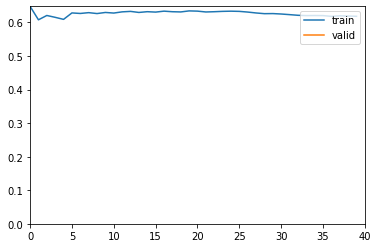

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.587258,0.516857,0.778287,0.841897,0.669811,00:35
1,0.581586,0.518338,0.773700,0.845528,0.654088,00:35
2,0.583708,0.512192,0.782875,0.833333,0.691824,00:35
3,0.575264,0.517710,0.781346,0.840467,0.679245,00:35
4,0.575493,0.516107,0.782875,0.841085,0.682390,00:35
5,0.573642,0.513810,0.782875,0.828358,0.698113,00:35


Better model found at epoch 0 with valid_loss value: 0.5168571472167969.


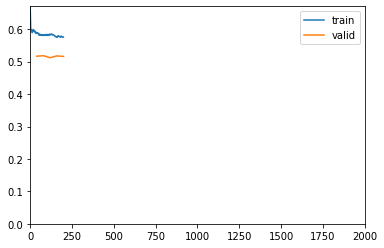

Better model found at epoch 2 with valid_loss value: 0.51219242811203.
No improvement since epoch 2: early stopping


In [23]:
learn.fine_tune(50,base_lr=1e-5)

In [24]:
learn.dls = dlsTest

In [25]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7347187995910645.


(#4) [0.5807849168777466,0.7347187995910645,0.7961956521739131,0.6735632183908046]